# Testing Machine Unlearning against Gaussian data poisoning

This is a sample implementation of gaussian data poisoning as described by the AI Security paper [Machine Unlearning Fails to Remove Data Poisoning Attacks
](https://arxiv.org/abs/2406.17216).

## Imports

In [1]:
from __future__ import annotations

from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules.loss import _Loss, CrossEntropyLoss
from torch.optim import Optimizer, SGD, AdamW
from torch.utils.data import Dataset, DataLoader
from torchvision.models import ResNet, resnet18
from torchmetrics.classification import MulticlassAccuracy
import torchinfo

In [2]:
from image_classification.utils import seed_all_generators, use_tqdm
from image_classification.accel import BEST_DEVICE, optimize_model
from image_classification.datasets import EagerDataset, cifar10_train_test
from image_classification.nn import (
    train_loop,
    test_epoch,
)
from image_classification.gaussian_poisoning import (
    GaussianPoisoningDataset,
    gaussian_unlearning_score,
)
from image_classification.unlearning import (
    gradient_descent,
    gradient_ascent,
    neg_grad_plus,
    oracle_unlearning,
    unlearning_last_layers,
    scrub,
    NoisySGD,
)

# For deterministic results
seed_all_generators(0x2023_2024)

# NOTE: Don't forget to clear all outputs in vscode before running.
# 
# WARNING (Windows): consider setting ascii=True and installing vscode-tqdm
# if notebook display issues persist: https://pypi.org/project/vscode-tqdm/
# Alternatively, set enable=False (but there won't be interactive output).
use_tqdm(enable=True, ascii=False)

Using cuda device


## Datasets

We work on the MNIST handwritten digits dataset.

### Get the dataset

In [3]:
training_data, test_data = cifar10_train_test(root='data')

N = len(training_data)
batch_size = 50

In [4]:
X = training_data.data
y = training_data.targets

In [5]:
def target_name(y: int) -> str:
    return training_data.classes[y]

### Poison the training samples

The attacker poisons a fraction $\varepsilon$ of the features with noise $(\xi_z)_{z \in S_\mathrm{poison}}$ and stores the noise for future usage.

In [6]:
# TODO: lower poison budget
poison_budget = 0.5
# TODO: lower noise value
noise_std = 0.5 * X.std().item()

corrupted_dataset = GaussianPoisoningDataset(
    training_data,
    poison_budget,
    noise_std,
)

S_poison: Tensor[bool] = corrupted_dataset.poison_support
N_poison = corrupted_dataset.num_poisons()
N_clean = N - N_poison

y_base: Tensor = y[S_poison.cpu()]
X_base: Tensor = corrupted_dataset.clean_dataset.data[S_poison]
X_poison: Tensor = corrupted_dataset.data[S_poison]
poisoning_noise: Tensor = corrupted_dataset.noise[S_poison]

# Another independent standard noise used as a baseline for unlearning evaluation
# (not used to corrupt the dataset)
dummy_noise = noise_std * torch.randn_like(poisoning_noise)

print(f'Clean data standard deviation: {X_base.std().item():.2g}')
print(f'Noise standard deviation: {poisoning_noise.std().item():.2g}')
print('Noise data for poisoning:', poisoning_noise.shape)

Clean data standard deviation: 1
Noise standard deviation: 0.5
Noise data for poisoning: torch.Size([25071, 3, 32, 32])


### Inspecting the poisoned data

In [7]:
def display_input_image(input: Tensor, label: Tensor, title='', cmap=None):
    """
    Displays an an input image to a neural network.

    `input`: a 3D tensor
    `cmap`: grayscale by default.
    """
    image = input.numpy(force=True)
    class_ = target_name(label.item())

    # Unnormalize CIFAR10 image to [0, 1]
    mean = np.array([0.4914, 0.4822, 0.4465]).reshape(3, 1, 1)
    std = np.array([0.247, 0.243, 0.261]).reshape(3, 1, 1)
    image = (std * image) + mean

    image = np.transpose(image, (1, 2, 0))

    fig, ax = plt.subplots()
    ax.imshow(image, cmap=cmap, interpolation='nearest')
    plt.title(class_)
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.029273970029834e-09..1.0000000339984894].


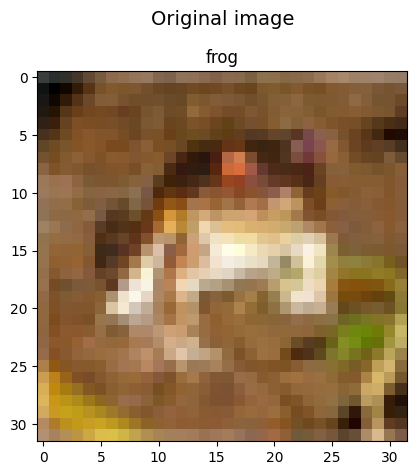

In [8]:
display_input_image(X_base[0], y_base[0], title='Original image')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.29255449438095094..1.2534009539604187].


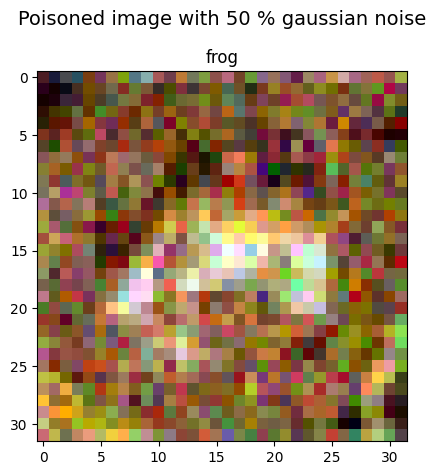

In [9]:
display_input_image(
    X_poison[0], y_base[0],
    title=f'Poisoned image with {int(100 * noise_std)} % gaussian noise'
)

Despite the amplitude of added noise, the image is still recognizable.

### Correlation between the poisoned data and the noise

In [10]:
# Estimate correlation between the `kx` coordinate of the samples `X`
# and the `ky` coordinate of the samples `Y`.
def correlation(X: Tensor, Y: Tensor, kx=0, ky=0):
    #return torch.corrcoef(X[:, kx], Y[:, ky])
    assert X.shape == Y.shape, f'Shape mismatch: {X.shape}, {Y.shape}'
    X = X.flatten(start_dim=1)
    Y = Y.flatten(start_dim=1)
    return np.corrcoef(X[:, kx].numpy(force=True), Y[:, ky].numpy(force=True), rowvar=False)

print(
    'Correlation matrix of clean samples and poisons\n',
    correlation(X_base, poisoning_noise)
)
print(
    'Correlation matrix of poisoned samples and fresh gaussians\n',
    correlation(X_base, dummy_noise)
)
print(
    'Correlation matrix of poisoned samples and poisons\n',
    correlation(X_poison, poisoning_noise)
)
print(
    'Correlation matrix of fresh gaussians and poisons\n',
    correlation(dummy_noise, poisoning_noise)
)

Correlation matrix of clean samples and poisons
 [[1.         0.00404856]
 [0.00404856 1.        ]]
Correlation matrix of poisoned samples and fresh gaussians
 [[1.         0.00544409]
 [0.00544409 1.        ]]
Correlation matrix of poisoned samples and poisons
 [[1.        0.3986664]
 [0.3986664 1.       ]]
Correlation matrix of fresh gaussians and poisons
 [[1.         0.00398965]
 [0.00398965 1.        ]]


The defender unknowingly collects corrupted data, which contains a small fraction of poisons.

From now on, we consider the following scenario :
1. The defender trains the model on the corrupted dataset.
2. The defender realizes afterwards they have been poisoned, and is able to determine which part of the dataset has been corrupted.
3. The defender runs the unlearning algorithm on the poisoned dataset.

We may also study a stronger relaxation of step 2 with the hypothesis that the defender is able to determine the exact values of the poisons. This unrealistic scenario may be used to prove that Machine Unlearning is necessarily vulnerable to data poisoning. Indeed, if Machine Unlearning fails with such strong assumptions, we may conclude the effect of data poisoning on the model parameters is simply irreversible.

## The model architecture

We use a convolutional neural network classifier on MNIST.

In [11]:
class Cifar10ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet18(num_classes=10)
    
    def forward(self, x):
        return self.resnet.forward(x).to('cpu')

In [12]:
model = Cifar10ResNet().to(BEST_DEVICE)

print(model)

Cifar10ResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [13]:
from image_classification.models import BigCNN

model = BigCNN(
    num_image_channels=3,
    image_size=32*32,
    num_classes=10,
    batchnorm=True,
    dropout_rate=0.2,
).to(BEST_DEVICE)

In [14]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
BigCNN                                   --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       448
│    └─BatchNorm2d: 2-2                  32
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─Conv2d: 2-5                       2,320
│    └─BatchNorm2d: 2-6                  32
│    └─ReLU: 2-7                         --
│    └─MaxPool2d: 2-8                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-9                       262,400
│    └─ReLU: 2-10                        --
│    └─Dropout: 2-11                     --
│    └─Linear: 2-12                      2,570
Total params: 267,802
Trainable params: 267,802
Non-trainable params: 0

## Train the model

### Clean sets, corrupted sets and poisons

In [15]:
# The retain set
clean_subset = corrupted_dataset.clean_subset()
clean_loader = DataLoader(clean_subset, batch_size, drop_last=True)

# The forget set
poisoned_subset = corrupted_dataset.poisoned_subset()
poisoned_loader = DataLoader(poisoned_subset, batch_size, drop_last=True)

# The forget set before poisoning
base_subset = corrupted_dataset.clean_subset_before_poisoning()
base_loader = DataLoader(base_subset, batch_size, drop_last=True)

# The clean test set
test_loader = DataLoader(test_data, batch_size, drop_last=True)

# The corrupted set (clean and poisons)
corrupted_loader = DataLoader(corrupted_dataset, batch_size, drop_last=True)

### Hyperparameters

In [16]:
lr = 1e-3
weight_decay = 1e-3

epochs = 3

loss_func = CrossEntropyLoss()

metric = MulticlassAccuracy(num_classes=10)

In [17]:
def make_optimizer(model: nn.Module, lr=lr, weight_decay=weight_decay) -> Optimizer:
    return AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

### Clean model

In [18]:
clean_model = deepcopy(model)
opt = make_optimizer(clean_model)
train_loop(clean_model, clean_loader, loss_func, opt, epochs=epochs)
test_epoch(clean_model, test_loader, loss_func, keep_pbars=True, metric=metric)

Train epochs:   0%|          | 0/3 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/24929 [00:00<?, ?it/s]

/home/lvt/.local/share/virtualenvs/ml-TQx6uCZG/lib/python3.13/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train loop: 100%|█████████▉| 24900/24929 [00:04<00:00, 5070.39it/s, loss=1.03]


Train loop:   0%|          | 0/24929 [00:00<?, ?it/s]

Train loop: 100%|█████████▉| 24900/24929 [00:03<00:00, 6614.03it/s, loss=0.867]


Train loop:   0%|          | 0/24929 [00:00<?, ?it/s]

Train loop: 100%|█████████▉| 24900/24929 [00:03<00:00, 7188.53it/s, loss=0.719]


Test loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 10000/10000 [00:00<00:00, 16755.87it/s, MulticlassAccuracy=0.591, avg_loss=1.1]


### Corrupted model

In [19]:
corrupted_model = deepcopy(model)
opt = make_optimizer(corrupted_model)
train_loop(corrupted_model, corrupted_loader, loss_func, opt, epochs=1)

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 50000/50000 [00:04<00:00, 10325.14it/s, loss=1.64]


In [20]:
#inspect_model(corrupted_model)

# FIXME: loss shouldn't be strictly equal to zero
print('\n\nOn the clean subset:')
test_epoch(corrupted_model, clean_loader, loss_func, keep_pbars=True, metric=metric)

print('\n\nOn the (clean) test set:')
test_epoch(corrupted_model, test_loader, loss_func, keep_pbars=True, metric=metric)

print('\n\nOn the original version of the poisoned subset before poisoning:')
test_epoch(corrupted_model, base_loader, loss_func, keep_pbars=True, metric=metric)

print('\n\nOn the poisoned subset:')
test_epoch(corrupted_model, poisoned_loader, loss_func, keep_pbars=True, metric=metric)




On the clean subset:


Test loop:   0%|          | 0/24929 [00:00<?, ?it/s]

Test loop: 100%|█████████▉| 24900/24929 [00:02<00:00, 10957.50it/s, MulticlassAccuracy=0.683, avg_loss=1.19]


On the (clean) test set:


Test loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 10000/10000 [00:00<00:00, 19549.34it/s, MulticlassAccuracy=0.613, avg_loss=1.22]


On the original version of the poisoned subset before poisoning:


Test loop:   0%|          | 0/25071 [00:00<?, ?it/s]

Test loop: 100%|█████████▉| 25050/25071 [00:02<00:00, 11152.19it/s, MulticlassAccuracy=0.55, avg_loss=1.2]


On the poisoned subset:


Test loop:   0%|          | 0/25071 [00:00<?, ?it/s]

Test loop: 100%|█████████▉| 25050/25071 [00:02<00:00, 9979.67it/s, MulticlassAccuracy=0.55, avg_loss=1.23]


### Are model outputs correlated to the noise?

In [21]:
corrupted_model(X_poison).shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.53 GiB. GPU 0 has a total capacity of 7.78 GiB of which 1.20 GiB is free. Including non-PyTorch memory, this process has 6.56 GiB memory in use. Of the allocated memory 6.11 GiB is allocated by PyTorch, and 236.37 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [20]:
dummy_noise.shape

torch.Size([9999, 3, 32, 32])

TODO: use spearman rank correlation coef. ?

In [21]:
#with torch.no_grad():
#    print(
#        'Correlation matrix of model outputs (before unlearning) and fresh noise\n',
#        correlation(corrupted_model(X_poison), dummy_noise)
#    )
#    print(
#        'Correlation matrix of model outputs (before unlearning) and poisoning noise\n',
#        correlation(corrupted_model(X_poison), poisoning_noise)
#    )

**Nope! But this computation does not make sense!**

### Model shift with poisoning

TODO: prove that model update direction is orthogonal

In [22]:
def model_to_tensor(model: nn.Module) -> Tensor:
    params = [
        param.detach().flatten()
        for param in model.parameters()
    ]
    return torch.cat(params)

def model_gradients(model: nn.Module) -> Tensor:
    params = [
        param.grad.detach().flatten()
        for param in model.parameters()
    ]
    return torch.cat(params)
        

In [23]:
def make_corrupted_dataset(
        poison_budget: float,
        eps: float = noise_std,
    ) -> GaussianPoisoningDataset:
    return GaussianPoisoningDataset(
        training_data,
        poison_budget,
        eps,
    )

def train_new_model_on(
        dataset: Dataset,
    ) -> Cifar10ResNet:
    corrupted_loader = DataLoader(dataset, batch_size, drop_last=True)

    poisoned_model = Cifar10ResNet().to(BEST_DEVICE)
    opt = make_optimizer(poisoned_model, lr=5e-3)
    train_loop(poisoned_model, corrupted_loader, loss_func, opt, epochs=epochs, keep_pbars=False)

    return poisoned_model

In [24]:
def model_relative_diff(
        clean_model: nn.Module,
        poisoned_model: nn.Module,
    ) -> float:
    clean_model.eval()
    poisoned_model.eval()

    theta_corr = model_to_tensor(poisoned_model)
    theta_clean = model_to_tensor(clean_model)
    diff = torch.norm(theta_corr - theta_clean, 1)
    return (diff / torch.norm(theta_clean, 1)).item()

In [25]:
model_relative_diff(clean_model, corrupted_model)

0.2358349859714508

In [26]:
from tqdm.auto import tqdm


def model_shift_against_poison_budget(n=30):
    poison_budgets = np.linspace(0.0, 1.0, n)
    rows = []
    for poison_budget in tqdm(poison_budgets, desc='Poison budget'):
        corrupted_data = make_corrupted_dataset(poison_budget)
        poisoned_model = train_new_model_on(corrupted_data)
        model_shift = model_relative_diff(clean_model, poisoned_model)
        rows.append([poison_budget, model_shift])
    
    return pd.DataFrame(rows, columns=['poison_budget', 'model_shift'])


In [27]:
df = model_shift_against_poison_budget(n=10)

Poison budget:   0%|          | 0/10 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/50000 [00:00<?, ?it/s]

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/50000 [00:00<?, ?it/s]

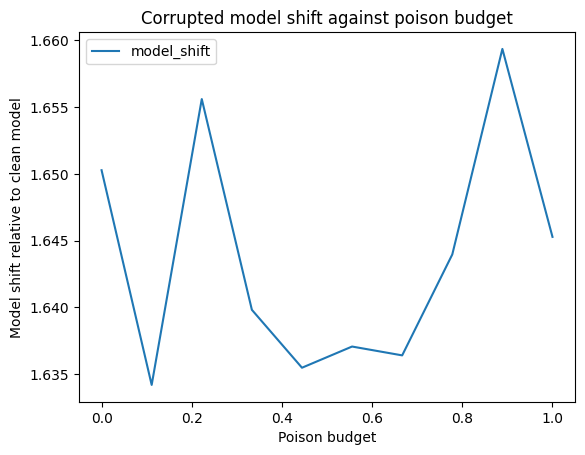

In [ ]:
df.plot.line(x='poison_budget', y='model_shift')
plt.xlabel('Poison budget')
plt.ylabel('Model shift relative to clean model')
plt.title('Corrupted model shift against poison budget')
plt.show()

FIXME: this is not coherent with the order of magnitude of the previous value!

In [29]:
def figure_5_a(
        clean_model: nn.Module,
        poisoned_model: nn.Module,
        clean_loader: DataLoader,
        loss_fn: _Loss,
    ):
    clean_model.eval()
    poisoned_model.eval()

    cos_sims = []

    theta_clean = model_to_tensor(clean_model)

    #def grad_hook(model: nn.Module, grad_input):
    #    theta = model_to_tensor(model)
    #    g = model_gradients(model)
    #    v = theta - theta_clean
    #    cos_sims.append(torch.cosine_similarity(v, g, dim=0).item())

    #handle = poisoned_model.register_full_backward_pre_hook(grad_hook)

    for X_b, y_b in clean_loader:
        loss = loss_fn(poisoned_model(X_b), y_b)
        loss.backward()

        g = model_gradients(poisoned_model)
        v = model_to_tensor(poisoned_model) - theta_clean
        cos_sims.append(torch.cosine_similarity(v, g, dim=0).item())
    
    cos_sims = np.array(cos_sims)

    #handle.remove()

    plt.hist(cos_sims, bins='rice')
    plt.xlabel(fr'$\langle v, g_t \rangle / \Vert v \Vert \Vert g_t \Vert$')
    
    axes = plt.gca()
    axes.xaxis.set_major_formatter('{x:.1e}')

    plt.title(fr'Cosine similarity between batch gradient updates and clean vs. poison model shift')
    plt.show()


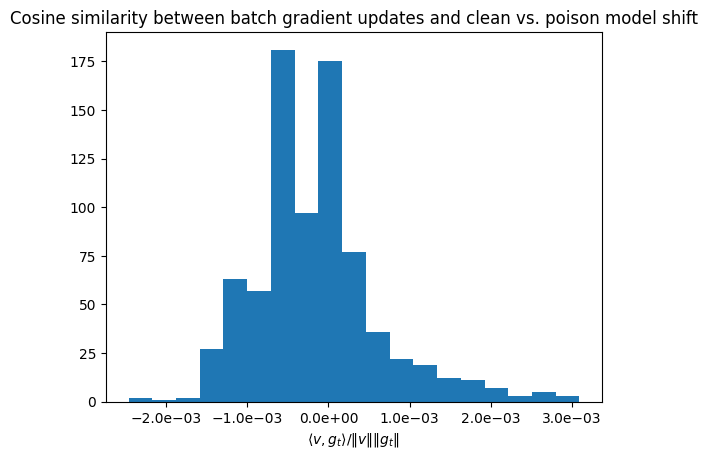

In [ ]:
figure_5_a(clean_model, corrupted_model, clean_loader, loss_func)

Interpretation: after poisoning, the model shift is orthogonal to the batch gradient updates, which means gradient-based methods fail to effectively unlearn the noise.

TODO: give a mathematical explanation for simple models

## Machine Unlearning

### Gradient Descent (GD)

> GD continues to train the model $\theta_{\mathrm{initial}}$ on the
remaining dataset $S_{\mathrm{train}} \setminus U$ by using gradient descent. In particular, we obtain $\theta_{\mathrm{updated}}$ via
> 
> $\theta_{t+1} \gets \theta_t − \eta g_t (\theta_t)$ with $\theta_1 = \theta_{\mathrm{initial}}$
> 
> where $\eta$ denotes the step size and $g_t$ denotes a (mini-batch) gradient computed for the the training
loss $\widehat{\mathbb{E}}_{(x,y) \in S_{\mathrm{train}} \setminus U} \left[l((x, y), \theta)\right]$ defined using the remaining dataset $S_{\mathrm{train}} \setminus U$, where $l$ is a loss function, e.g., cross-entropy loss, hinge loss, etc.

### Gradient Ascent (GA)

> GA is an unlearning algorithm which attempts to remove the influence of the forget set $U$ from the trained model by simply reversing the gradient updates that contain information about $U$. In particular, we update via
> 
> $\theta_{t+1} \gets \theta_t + \eta g_t (\theta_t)$ with $\theta_1 = \theta_{\mathrm{initial}}$
> 
> where $g_t$ denotes a (mini-batch) gradient computed for the the training loss $\widehat{\mathbb{E}}_{(x,y) \in U} \left[l((x, y), \theta)\right]$ on the deletion
set.

## Evaluate the effect of Gaussian data poisoning

We follow the *Algorithm 3* in the original paper of Pawelczyk et al.

In [31]:
# NOTE: the computed standard deviation might not be 1 due to gradient vanishing
def evaluate_unlearning(
        model: nn.Module,
        base_data: Dataset,
        noise: Dataset,
        noise_std: float,
        loss_fn: _Loss,
        xi_name=r'$\xi$', g_name='g', method='',
    ):
    I_poison = gaussian_unlearning_score(
        model,
        base_data,
        noise,
        noise_std,
        loss_fn,
    )

    mean = I_poison.mean()
    std = I_poison.std()

    mean_std_theory = 1. / np.sqrt(float(len(noise)))

    plt.hist(I_poison, density=True)

    iz = np.linspace(I_poison.min(), I_poison.max())
    distr = stats.norm(mean, std)
    plt.plot(iz, distr.pdf(iz), label=fr'Gaussian fit: $\mathcal{{N}}({mean:.3}, {std**2:.3})$')
    
    distr = stats.norm(0.0, 1.0)
    plt.plot(iz, distr.pdf(iz), label=fr'Theory: $\mathcal{{N}}(0 \pm {mean_std_theory:.3g}, 1)$')

    plt.xlabel(fr'$\mathcal{{I}}_{{\mathrm{{poison}}}} = \frac{{\langle \xi, {g_name} \rangle}}{{\epsilon ||{g_name}||_2}}$')
    plt.title(fr'Normalized dot product distribution between input gradients ${g_name}$ and {xi_name}')
    if method:
        plt.suptitle(method)
    plt.legend()
    plt.show()

In [32]:
from image_classification.gaussian_poisoning import gaussian_unlearning_score

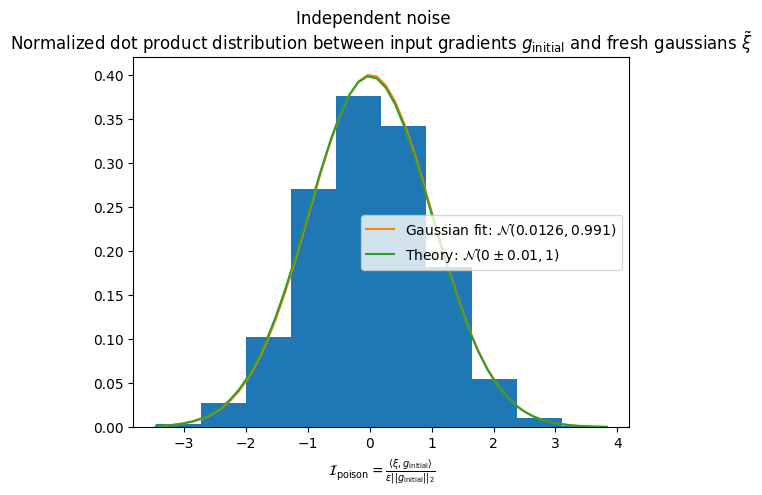

In [ ]:
loss_func_no_reduction = CrossEntropyLoss(reduction='none')

evaluate_unlearning(
    corrupted_model, base_subset, dummy_noise, noise_std, loss_func_no_reduction,
    xi_name=r'fresh gaussians $\tilde{\xi}$', g_name=r'g_{\mathrm{initial}}', method='Independent noise'
)

When testing against independent noise, the result should be equivalent to perfect unlearning.

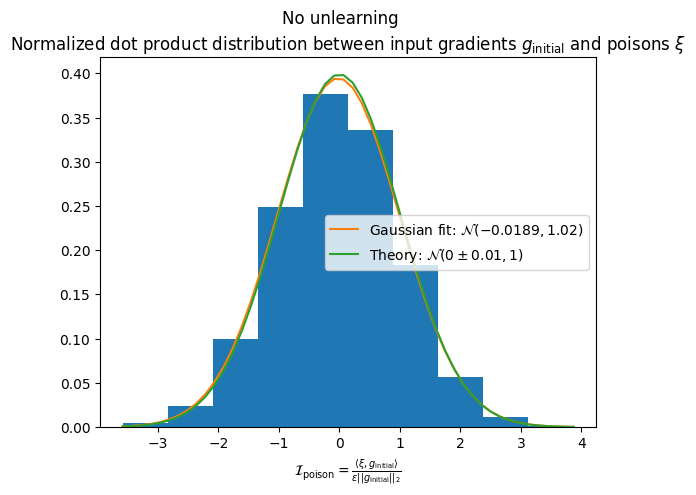

In [ ]:
evaluate_unlearning(
    corrupted_model, base_subset, poisoning_noise, noise_std, loss_func_no_reduction,
    xi_name=r'poisons $\xi$', g_name=r'g_{\mathrm{initial}}', method='No unlearning'
)

For fresh Gaussians, the distribution should be centered around $0$.

Due to data poisoning, the model gradients are influenced by $\xi$ so the distribution is shifted.

FIXME: actually, there is very little correlation because the model seems to have minimized the loss over the clean samples rather than the poisoned samples, which is why the loss gradient is not correlated with the noise.

### Evaluate unlearning algorithms

We plot the previous distribution again, after running the unlearning algorithm.
If the distribution is still shifted, that means the model did not perfectly unlearn the poisons.

In [35]:
def display_post_unlearning_results(model: nn.Module, algo_name: str):
    print('\n\nTest on clean samples:')
    test_epoch(model, test_loader, loss_func, keep_pbars=True, metric=metric)
    print('\n\nTest on poisoned samples:')
    test_epoch(model, poisoned_loader, loss_func, keep_pbars=True, metric=metric)
    print('\n\n')
    evaluate_unlearning(
        model, base_subset, poisoning_noise, noise_std, loss_func_no_reduction,
        xi_name=r'Gaussian poisons $\xi$',
        g_name=r'g_{\mathrm{updated}}',
        method=algo_name,
    )

### Gradient descent

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40001 [00:00<?, ?it/s]

Train loop: 100%|█████████▉| 40000/40001 [00:11<00:00, 3606.46it/s, loss=0.818]


Test loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 10000/10000 [00:01<00:00, 8463.07it/s, avg_loss=0.917]


Test on clean samples:


Test loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 10000/10000 [00:01<00:00, 8349.67it/s, MulticlassAccuracy=0.634, avg_loss=0.917]


Test on poisoned samples:


Test loop:   0%|          | 0/9999 [00:00<?, ?it/s]

Test loop: 100%|█████████▉| 9950/9999 [00:01<00:00, 6482.70it/s, MulticlassAccuracy=0.576, avg_loss=0.896]





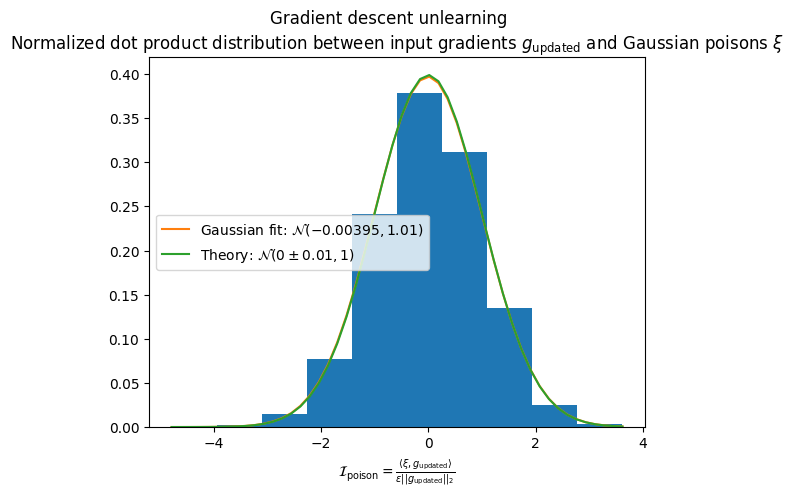

In [36]:
unlearner = deepcopy(corrupted_model)
opt_gd = make_optimizer(unlearner, lr=0.5 * lr)
gradient_descent(unlearner, clean_loader, test_loader, loss_func, opt_gd, epochs=1)
display_post_unlearning_results(unlearner, algo_name='Gradient descent unlearning')

### Noisy gradient descent

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40001 [00:00<?, ?it/s]

Train loop: 100%|█████████▉| 40000/40001 [00:08<00:00, 4837.96it/s, loss=0.864]


Test loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 10000/10000 [00:00<00:00, 10310.73it/s, avg_loss=1.09]


Test on clean samples:


Test loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 10000/10000 [00:01<00:00, 8418.62it/s, MulticlassAccuracy=0.648, avg_loss=1.09]


Test on poisoned samples:


Test loop:   0%|          | 0/9999 [00:00<?, ?it/s]

Test loop: 100%|█████████▉| 9950/9999 [00:01<00:00, 7447.02it/s, MulticlassAccuracy=0.77, avg_loss=1.05]





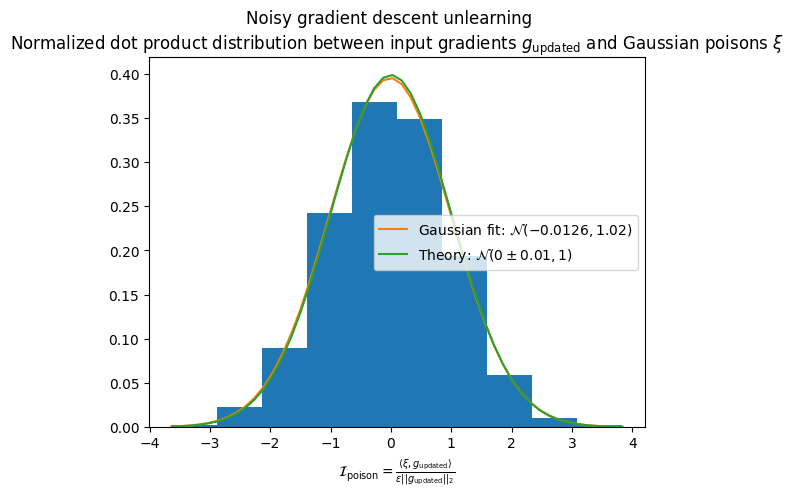

In [37]:
unlearner = deepcopy(corrupted_model)
opt_ngd = NoisySGD(unlearner.parameters(), noise_scale=np.sqrt(1e-6), lr=1e-1)
gradient_descent(unlearner, clean_loader, test_loader, loss_func, opt_gd, epochs=1)
display_post_unlearning_results(unlearner, algo_name='Noisy gradient descent unlearning')

### Gradient ascent

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40001 [00:00<?, ?it/s]

Train loop: 100%|█████████▉| 40000/40001 [00:11<00:00, 3635.63it/s, loss=-158]


Test loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 10000/10000 [00:01<00:00, 8612.95it/s, avg_loss=-157]


Test on clean samples:


Test loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 10000/10000 [00:01<00:00, 8736.07it/s, MulticlassAccuracy=0, avg_loss=157]


Test on poisoned samples:


Test loop:   0%|          | 0/9999 [00:00<?, ?it/s]

Test loop: 100%|█████████▉| 9950/9999 [00:01<00:00, 6562.79it/s, MulticlassAccuracy=0.02, avg_loss=157]





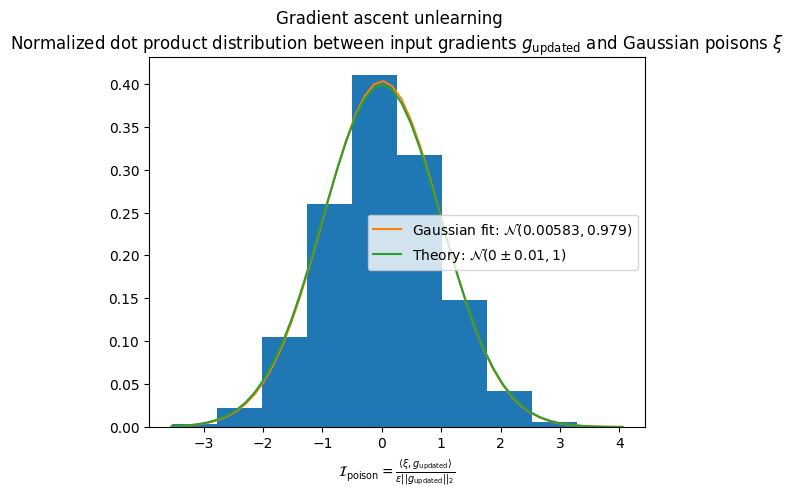

In [38]:
unlearner = deepcopy(corrupted_model)
opt_ga = make_optimizer(unlearner, lr=0.1 * lr)
gradient_ascent(unlearner, clean_loader, test_loader, loss_func, opt_ga, epochs=epochs)
display_post_unlearning_results(unlearner, algo_name='Gradient ascent unlearning')

Gradient ascent completely fails to maintain a good overall performance. Seems like the algorithm is overfitting on unlearning.

### NegGrad+

In [ ]:
unlearner = deepcopy(corrupted_model)
opt_ngp = make_optimizer(unlearner, lr=lr)
neg_grad_plus(unlearner, clean_loader, poisoned_loader, loss_func, opt_ngp, beta=0.995)
display_post_unlearning_results(unlearner, algo_name='NegGrad+')

NegGrad+:   0%|          | 0/9999 [00:00<?, ?it/s]

NegGrad+: 100%|█████████▉| 9950/9999 [00:04<00:00, 2167.07it/s, loss=0.99, loss_forget=1.27, loss_retain=1]


Test on clean samples:


Test loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Test loop: 100%|██████████| 10000/10000 [00:01<00:00, 7225.94it/s, MulticlassAccuracy=0.543, avg_loss=1.13]


Test on poisoned samples:


Test loop:   0%|          | 0/9999 [00:00<?, ?it/s]

Test loop: 100%|█████████▉| 9950/9999 [00:01<00:00, 5865.44it/s, MulticlassAccuracy=0.502, avg_loss=1.11]





KeyboardInterrupt: 

### Oracle unlearning (ours)

In [ ]:
unlearner = deepcopy(corrupted_model)
# TODO:
# Future work: how to set learning rate according to GUS? Is GUS a relevant metric?
opt_oracle = make_optimizer(unlearner, lr=0.1 * lr)

oracle_unlearning(unlearner, base_loader, poisoned_loader, loss_func, opt_oracle)
display_post_unlearning_results(unlearner, algo_name='Oracle')

### CFk

In [ ]:
unlearner = deepcopy(corrupted_model)
with unlearning_last_layers(unlearner, 1, mode='cfk'):
    opt_cfk = make_optimizer(unlearner, lr=0.5 * lr)
    train_loop(unlearner, clean_loader, loss_func, opt_cfk, epochs=1)
display_post_unlearning_results(unlearner, algo_name='CFk')

### EUk

In [ ]:
unlearner = deepcopy(corrupted_model)
with unlearning_last_layers(unlearner, 1, mode='euk'):
    opt_euk = make_optimizer(unlearner, lr=0.5 * lr)
    train_loop(unlearner, clean_loader, loss_func, opt_euk, epochs=epochs)
display_post_unlearning_results(unlearner, algo_name='EUk')

### SCRUB

In [ ]:
teacher = deepcopy(corrupted_model)
student = deepcopy(teacher)
opt_scrub = make_optimizer(unlearner, lr=lr)
scrub(
    teacher, student,
    clean_loader, poisoned_loader,
    loss_func, opt_scrub,
    max_steps=epochs, steps=epochs,
)
display_post_unlearning_results(unlearner, algo_name='SCRUB')

## Takeaways

Disclaimer: the experiment results do not provide strong evidence.

Ablation study :

- Larger models are more vulnerable to data poisoning. Indeed, when the model dimension is very high compared to the feature dimension, the model is likely to overfit on the poisons, therefore making them hard to forget.
- Data poisoning has a larger effect on high-dimensioned data. We should adapt our experiment to images to see the difference.
- For simple problems such as linear regression, the effect of data poisoning seems to decrease as the number of samples grows. To get an intuition of why this is true, consider the $1$-dimensional linear regression: the estimated slope coefficient converges to the true slope coefficient, even if the training data is poisoned.
- Techniques such as gradient ascent unlearning (GA) are more efficient at removing poisons, however the model becomes widly inaccurate on the base dataset. This highlights the tradeoff between privacy and usefulness. For unlearning, we need to make a compromise between GD and GA.